/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_23361/541340915.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["occurrence_rank"] = df.groupby(["platform", "query_type"]).cumcount() + 1
/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_23361/541340915.py:107: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return data.groupby(["platform", "query_type"], group_keys=False).apply(iqr_clip)
/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_23361/541340915.py:107: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a f


=== Overall SedonaDB Performance Advantage ===
SedonaDB vs PostGIS: 68.38% faster
SedonaDB vs TimescaleDB: 68.38% faster
SedonaDB vs SpaceTime: 80.59% faster
SedonaDB vs MobilityDB: 98.81% faster
SedonaDB vs MobilityDB_Time_Partitioned: 97.37% faster
SedonaDB vs MobilityDB_Space_Partitioned: 98.50% faster


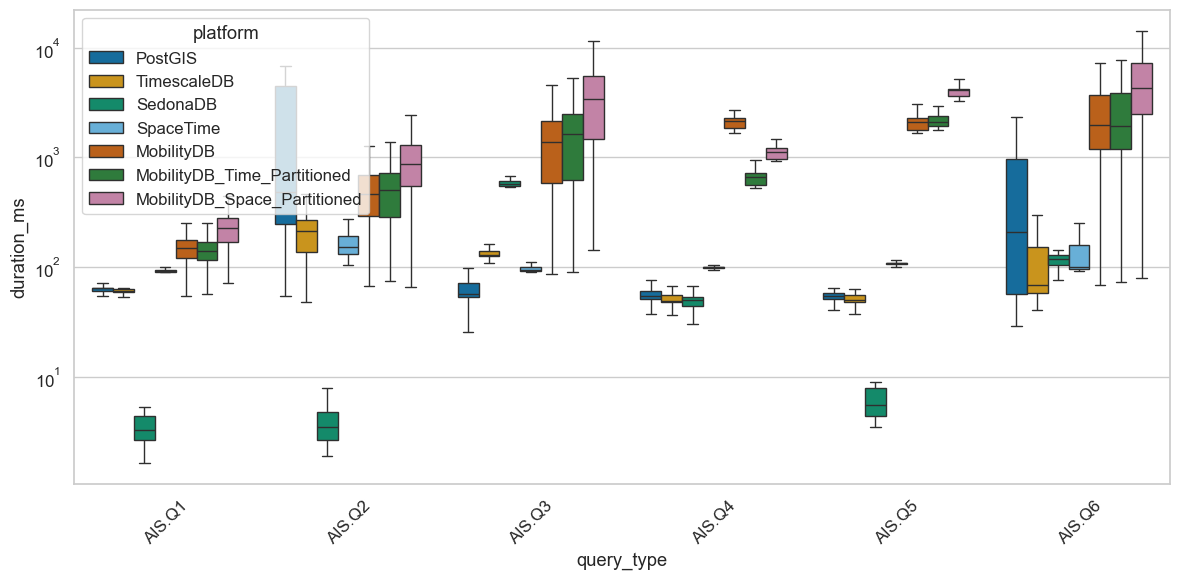

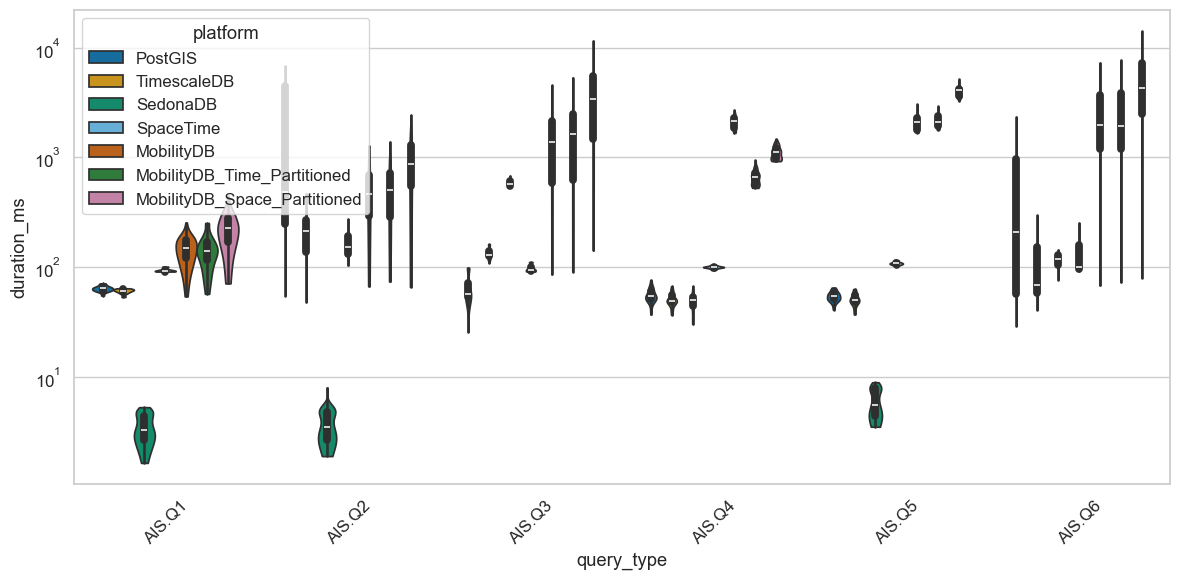

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


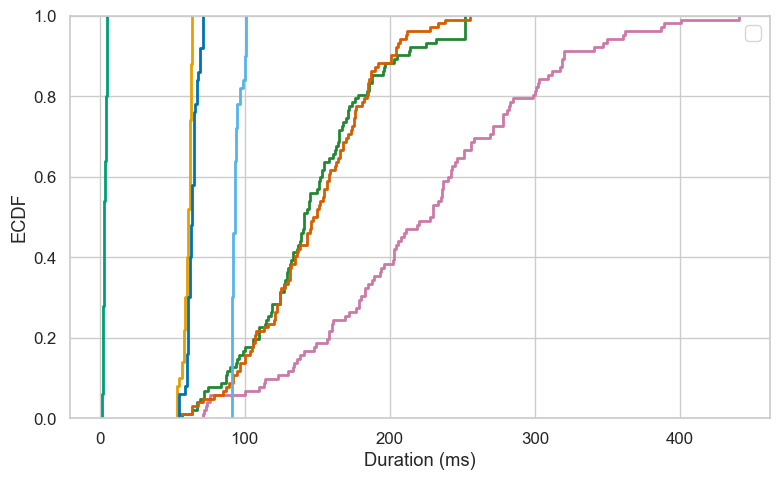

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


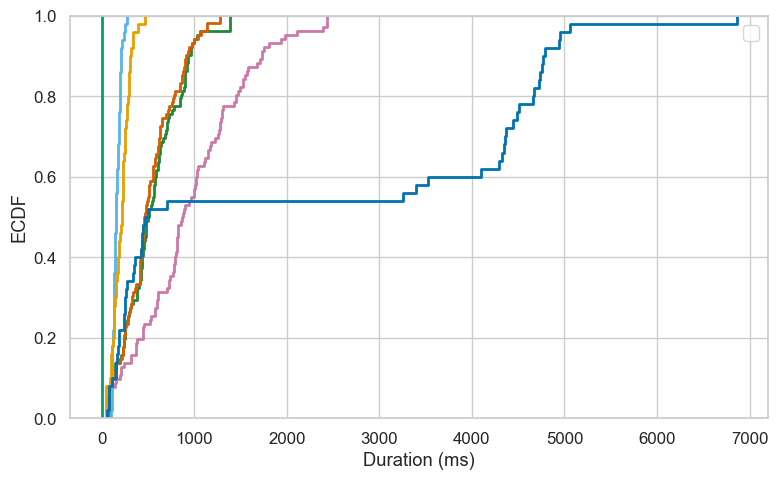

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


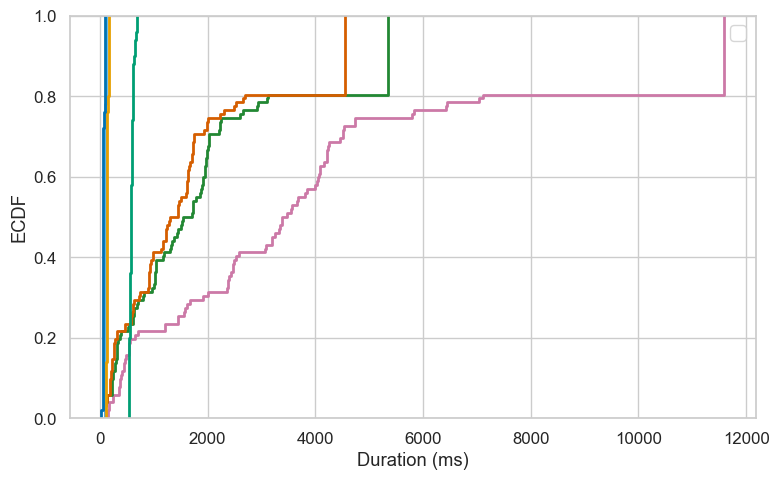

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


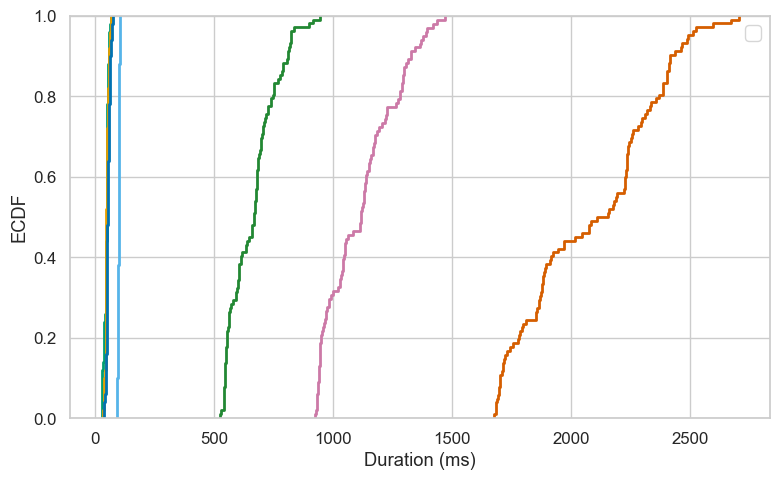

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


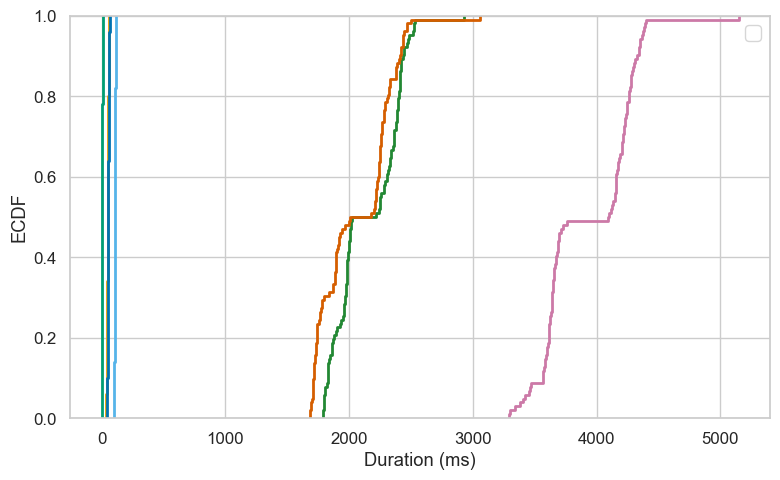

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


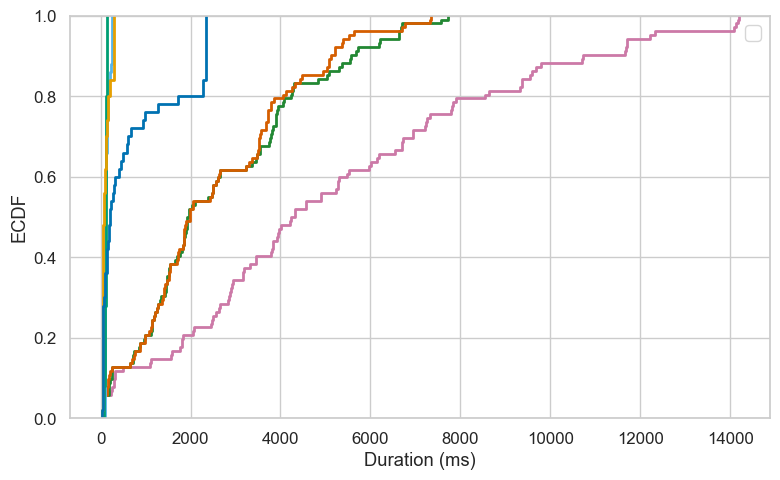

✅ Plots created.


In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from itertools import combinations


 #---------------- Query mapping ----------------
QUERY_RENAME_MAP = {
    "SortRidesByHourInPeriod": "Cyc.Q1",
    "averageRideDurationDuringDay": "Cyc.Q2",
    "countActiveRideInDistrict": "Cyc.Q3",
    "RidesPastOrToUniversity": "Cyc.Q4",
    "averageRideDurationToGoAtUniversityInPeriod": "Cyc.Q5",
    "rideCrossSeveralDistrictsInPeriod": "Cyc.Q6",
}

QUERY_ORDER = ["Cyc.Q1", "Cyc.Q2", "Cyc.Q3", "Cyc.Q4", "Cyc.Q5", "Cyc.Q6"]


QUERY_RENAME_MAP = { "countActiveCrossingsInPeriod": "AIS.Q1", 
 "CrossingsActiveAtGivenHourOfDay": "AIS.Q2", 
 "countActiveCrossingsNearIsland": "AIS.Q3", 
 "crossingsConnectTwoGivenHarbours": "AIS.Q4", 
 "averageDurationCrossingStartAtHarbourInPeriod": "AIS.Q5", 
 "HarbourActivityInPeriod": "AIS.Q6", 
 } 
 
QUERY_ORDER = ["AIS.Q1", "AIS.Q2", "AIS.Q3", "AIS.Q4", "AIS.Q5", "AIS.Q6"]
# ---------------- Platform order + improved colors ----------------
PLATFORM_ORDER = [
    "PostGIS",
    "TimescaleDB",
    "SedonaDB",
    "SpaceTime",
    "MobilityDB",
    "MobilityDB_Time_Partitioned",
    "MobilityDB_Space_Partitioned",
]

PLATFORM_COLORS = {
    "PostGIS": "#0072B2",                    # deep blue
    "TimescaleDB": "#E69F00",                # orange
    "SedonaDB": "#009E73",                   # teal green
    "SpaceTime": "#56B4E9",                  # LIGHTER BLUE (distinct)
    "MobilityDB": "#D55E00",                 # vermillion
    "MobilityDB_Time_Partitioned": "#228833",# darker green
    "MobilityDB_Space_Partitioned": "#CC79A7"# purple
}


def analyze_queries(file_ending: str):
    log_dir = Path("../logs")

    log_pattern = re.compile(
        r"\[.*?\]\s+\[(?P<platform>[\w_]+)\]\s+\[.*?\]\s+SUCCESS:\s+'(?P<query>[^']+)':\s+(?P<duration>\d+)ms"
    )
    log_pattern_alt = re.compile(
        r"\[?(?P<platform>[\w_]+)\]?\s+\[(?P<query>\w+)\]\s+query:\s+(?P<query_name>[^:]+):\s+(?P<duration>\d+\.?\d*)ms"
    )

    log_files = list(log_dir.glob(f"*{file_ending}.log"))
    if not log_files:
        print("No log files found.")
        return

    all_data = []
    for log_file in log_files:
        with open(log_file, "r", encoding="utf-8") as f:
            for line in f:
                match = log_pattern.search(line)
                if match:
                    all_data.append({
                        "platform": match.group("platform"),
                        "query_type": match.group("query"),
                        "duration_ms": int(match.group("duration")),
                    })
                else:
                    match_alt = log_pattern_alt.search(line)
                    if match_alt:
                        all_data.append({
                            "platform": match_alt.group("platform"),
                            "query_type": match_alt.group("query_name"),
                            "duration_ms": float(match_alt.group("duration")),
                        })

    df = pd.DataFrame(all_data)

    df["query_type"] = df["query_type"].replace(QUERY_RENAME_MAP)
    df["query_type"] = pd.Categorical(df["query_type"], categories=QUERY_ORDER, ordered=True)
    df["platform"] = pd.Categorical(df["platform"], categories=PLATFORM_ORDER, ordered=True)

    # Remove warm-up runs
    df["occurrence_rank"] = df.groupby(["platform", "query_type"]).cumcount() + 1
    df = df[df["occurrence_rank"] > 2]

    # Outlier clipping
    def clip_outliers_iqr(data, column):
        def iqr_clip(group):
            q1 = group[column].quantile(0.25)
            q3 = group[column].quantile(0.75)
            iqr = q3 - q1
            lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
            group[column] = group[column].clip(lower, upper)
            return group
        return data.groupby(["platform", "query_type"], group_keys=False).apply(iqr_clip)

    df = clip_outliers_iqr(df, "duration_ms")

        # --- Compute median runtime per platform + query ---
    # --- Single overall median runtime per platform ---
    overall_median = (
        df.groupby("platform")["duration_ms"]
        .median()
    )

    # --- Compare SedonaDB vs others ---
    sedona_time = overall_median["SedonaDB"]

    print("\n=== Overall SedonaDB Performance Advantage ===")
    for platform, value in overall_median.items():
        if platform == "SedonaDB":
            continue

        improvement = (value - sedona_time) / value * 100
        print(f"SedonaDB vs {platform}: {improvement:.2f}% faster")



    sns.set(style="whitegrid", font_scale=1.1)

    # Boxplot
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(
        data=df,
        x="query_type",
        y="duration_ms",
        hue="platform",
        palette=PLATFORM_COLORS,
    )
    ax.set_yscale("log")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"query_boxplot_comparison_{file_ending}.pdf", dpi=300)
    plt.show()

    # Violin plot
    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(
        data=df,
        x="query_type",
        y="duration_ms",
        hue="platform",
        palette=PLATFORM_COLORS,
        cut=0,
    )
    ax.set_yscale("log")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"query_violin_comparison_{file_ending}.pdf", dpi=300)
    plt.show()

    # ECDF
    for query in sorted(df["query_type"].dropna().unique()):
        subset = df[df["query_type"] == query]
        plt.figure(figsize=(8, 5))

        ax = sns.ecdfplot(
            data=subset,
            x="duration_ms",
            hue="platform",
            palette=PLATFORM_COLORS,
            linewidth=2,
        )

        # Force proper legend with fontsize
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, fontsize=14, title="Platform")


        plt.ylabel("ECDF")
        plt.xlabel("Duration (ms)")

        # Fix legend font size properly
        plt.tight_layout()
        plt.savefig(f"ecdf_{query}_{file_ending}.pdf", dpi=300)
        plt.show()


    print("✅ Plots created.")


if __name__ == "__main__":
    analyze_queries("9430d")


📁 Found 6 MobilityDB logs containing 'c0fbe':
  • MobilityDB_Time_Partitionedquery_results_c0fbe.log
  • MobilityDB_spgist_Time_Partitionedquery_results_c0fbe.log
  • MobilityDB_Space_Partitionedquery_results_c0fbe.log
  • MobilityDB_spgist_Space_Partitionedquery_results_c0fbe.log
  • MobilityDBquery_results_c0fbe.log
  • MobilityDB_spgist_query_results_c0fbe.log
Parsed 1872 entries.


/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_23361/3548890815.py:104: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["platform_label", "query_type"]).cumcount() + 1
/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_23361/3548890815.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(["platform_label", "query_type"], group_keys=False).apply(clip_outliers)
/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_23361/3548890815.py:117: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future v

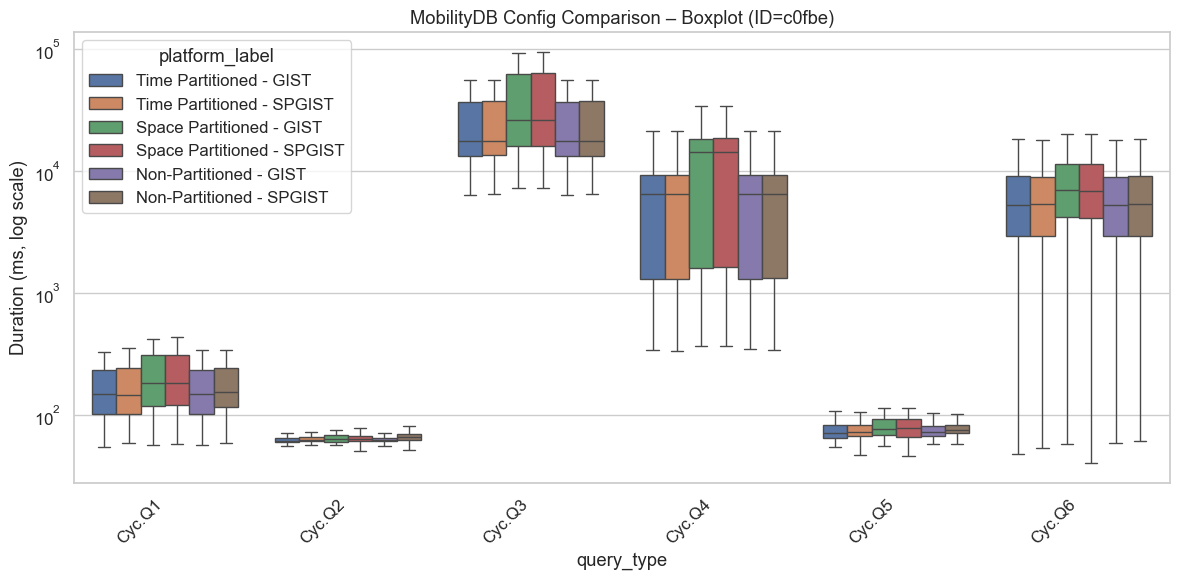


📊 Median durations (ms):
platform_label  Non-Partitioned - GIST  Non-Partitioned - SPGIST  \
query_type                                                         
Cyc.Q1                           148.0                     156.0   
Cyc.Q2                            62.5                      66.5   
Cyc.Q3                         17600.5                   17560.0   
Cyc.Q4                          6455.0                    6488.0   
Cyc.Q5                            73.0                      76.0   
Cyc.Q6                          5315.5                    5356.0   

platform_label  Space Partitioned - GIST  Space Partitioned - SPGIST  \
query_type                                                             
Cyc.Q1                             185.0                       184.5   
Cyc.Q2                              64.5                        63.5   
Cyc.Q3                           26078.0                     26247.5   
Cyc.Q4                           14429.0                     14404.0 

/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_23361/3548890815.py:139: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["platform_label", "query_type"])["duration_ms"]
/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_23361/3548890815.py:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["platform", "query_type"])["duration_ms"]
/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_23361/3548890815.py:181: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

(              platform query_type  duration_ms  \
 5     Time Partitioned     Cyc.Q1      112.000   
 7     Time Partitioned     Cyc.Q2       62.000   
 8     Time Partitioned     Cyc.Q2       71.875   
 11    Time Partitioned     Cyc.Q2       60.000   
 12    Time Partitioned     Cyc.Q1       56.000   
 ...                ...        ...          ...   
 1867   Non-Partitioned     Cyc.Q2       68.000   
 1868   Non-Partitioned     Cyc.Q2       59.000   
 1869   Non-Partitioned     Cyc.Q1      310.000   
 1870   Non-Partitioned     Cyc.Q6     5975.000   
 1871   Non-Partitioned     Cyc.Q4     8887.000   
 
                                               source storage_type  \
 5     MobilityDB_Time_Partitionedquery_results_c0fbe         GIST   
 7     MobilityDB_Time_Partitionedquery_results_c0fbe         GIST   
 8     MobilityDB_Time_Partitionedquery_results_c0fbe         GIST   
 11    MobilityDB_Time_Partitionedquery_results_c0fbe         GIST   
 12    MobilityDB_Time_Partitionedqu

In [14]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ---------------------------------------
# Query rename mapping + enforced order
# ---------------------------------------
QUERY_RENAME_MAP = {
    "SortRidesByHourInPeriod": "Cyc.Q1",
    "averageRideDurationDuringDay": "Cyc.Q2",
    "countActiveRideInDistrict": "Cyc.Q3",
    "RidesPastOrToUniversity": "Cyc.Q4",
    "averageRideDurationToGoAtUniversityInPeriod": "Cyc.Q5",
    "rideCrossSeveralDistrictsInPeriod": "Cyc.Q6",
}

QUERY_ORDER = ["Cyc.Q1", "Cyc.Q2", "Cyc.Q3", "Cyc.Q4", "Cyc.Q5", "Cyc.Q6"]


def analyze_mobilitydb_logs(log_id: str, log_dir="../logs"):
    log_dir = Path(log_dir)

    log_files = [
        f for f in log_dir.glob("*.log")
        if "MobilityDB" in f.name and log_id in f.name
    ]

    if not log_files:
        print(f"❌ No MobilityDB log files found with ID '{log_id}' in {log_dir}")
        return None, None

    print(f"📁 Found {len(log_files)} MobilityDB logs containing '{log_id}':")
    for f in log_files:
        print("  •", f.name)

    # Parsing patterns
    log_pattern = re.compile(
        r"\[.*?\]\s+\[(?P<platform>\w+)\]\s+\[.*?\]\s+SUCCESS:\s+'(?P<query>[^']+)':\s+(?P<duration>\d+)ms"
    )

    log_pattern_alt = re.compile(
        r"\[?(?P<platform>\w+)\]?\s+\[(?P<query>\w+)\]\s+query:\s+(?P<query_name>[^:]+):\s+(?P<duration>\d+\.?\d*)ms"
    )

    all_data = []

    for log_file in log_files:
        with open(log_file, "r", encoding="utf-8") as f:
            for line in f:
                m = log_pattern.search(line)
                if m:
                    all_data.append({
                        "platform": m.group("platform"),
                        "query_type": m.group("query"),
                        "duration_ms": float(m.group("duration")),
                        "source": log_file.stem,
                    })
                else:
                    m2 = log_pattern_alt.search(line)
                    if m2:
                        all_data.append({
                            "platform": m2.group("platform"),
                            "query_type": m2.group("query_name"),
                            "duration_ms": float(m2.group("duration")),
                            "source": log_file.stem,
                        })

    if not all_data:
        print("❌ No log entries parsed.")
        return None, None

    df = pd.DataFrame(all_data)
    print(f"Parsed {len(df)} entries.")

    # Platform grouping
    def rename_platform(name: str) -> str:
        name = name.replace(log_id, "")
        if "Space_Partitioned" in name:
            return "Space Partitioned"
        if "Time_Partitioned" in name:
            return "Time Partitioned"
        return "Non-Partitioned"

    df["platform"] = df["source"].apply(rename_platform)

    # Storage type
    df["storage_type"] = df["source"].apply(
        lambda x: "SPGIST" if "spgist" in x.lower() else "GIST"
    )

    df["platform_label"] = df["platform"] + " - " + df["storage_type"]

    # Rename query types
    df["query_type"] = df["query_type"].replace(QUERY_RENAME_MAP)

    df["query_type"] = pd.Categorical(
        df["query_type"], categories=QUERY_ORDER, ordered=True
    )

    # Remove warm-ups
    df["occurrence_rank"] = (
        df.groupby(["platform_label", "query_type"]).cumcount() + 1
    )
    df = df[df["occurrence_rank"] > 2].copy()

    # Outlier clipping
    def clip_outliers(group):
        q1 = group["duration_ms"].quantile(0.25)
        q3 = group["duration_ms"].quantile(0.75)
        iqr = q3 - q1
        return group.assign(
            duration_ms=group["duration_ms"].clip(q1 - 1.5 * iqr, q3 + 1.5 * iqr)
        )

    df = df.groupby(["platform_label", "query_type"], group_keys=False).apply(clip_outliers)

    df["duration_ms"] = df["duration_ms"].clip(lower=1)

    # -----------------------------
    # Plotting
    # -----------------------------
    sns.set(style="whitegrid", font_scale=1.1)

    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(data=df, x="query_type", y="duration_ms", hue="platform_label")
    ax.set_yscale("log")
    plt.title(f"MobilityDB Config Comparison – Boxplot (ID={log_id})")
    plt.ylabel("Duration (ms, log scale)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Median summary table
    # -----------------------------
    summary = (
        df.groupby(["platform_label", "query_type"])["duration_ms"]
        .median()
        .reset_index()
        .pivot(index="query_type", columns="platform_label", values="duration_ms")
    )

    print("\n📊 Median durations (ms):")
    print(summary)

    # ======================================================
    # PARTITIONING IMPACT (Space vs Time vs Non-Partitioned)
    # ======================================================
    partition_medians = (
        df.groupby(["platform", "query_type"])["duration_ms"]
        .median()
        .reset_index()
        .pivot(index="query_type", columns="platform", values="duration_ms")
    )

    if "Non-Partitioned" in partition_medians.columns:
        baseline = partition_medians["Non-Partitioned"]

        pct_changes = {}
        for col in ["Space Partitioned", "Time Partitioned"]:
            if col in partition_medians.columns:
                pct_changes[col] = (partition_medians[col] - baseline) / baseline * 100

        pct_df = pd.DataFrame(pct_changes)

        print("\n📊 Partitioning change per query (% vs Non-Partitioned):")
        print(pct_df)

        print("\n⭐ Average change vs baseline:")
        for col in pct_df.columns:
            avg = pct_df[col].mean()
            direction = "faster" if avg < 0 else "slower"
            print(f"  • {col}: {abs(avg):.2f}% {direction}")

    # ======================================================
    # SPGIST vs GIST IMPACT (overall index comparison)
    # ======================================================
    index_medians = (
        df.groupby(["storage_type", "query_type"])["duration_ms"]
        .median()
        .reset_index()
        .pivot(index="query_type", columns="storage_type", values="duration_ms")
    )

    if "GIST" in index_medians.columns and "SPGIST" in index_medians.columns:
        pct_change = (index_medians["SPGIST"] - index_medians["GIST"]) / index_medians["GIST"] * 100

        print("\n📊 SPGIST vs GIST per query (%):")
        print(pct_change)

        avg_change = pct_change.mean()
        direction = "faster" if avg_change < 0 else "slower"

        print(f"\n⭐ Overall: SPGIST is {abs(avg_change):.2f}% {direction} than GIST on average.")

    return df, summary


# Run example
analyze_mobilitydb_logs("c0fbe")

/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_23361/3612290997.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["occurrence_rank"] = df.groupby(
/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_23361/3612290997.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(["platform", "query_type"], group_keys=False).apply(clip)
/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_23361/3612290997.py:83: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns w

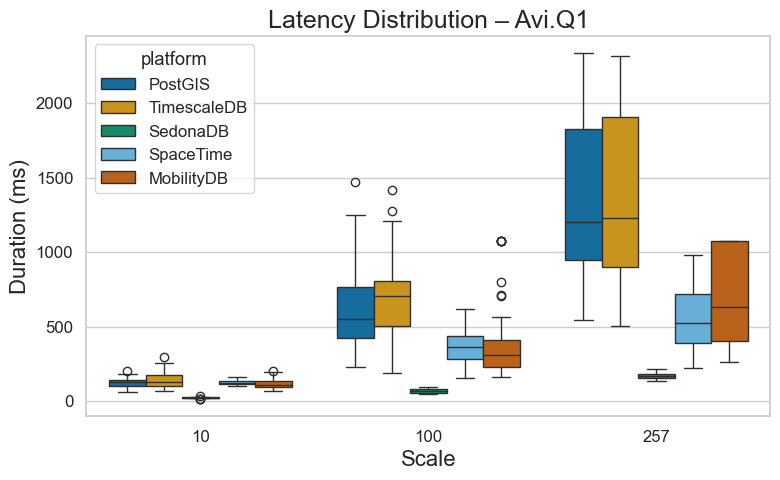

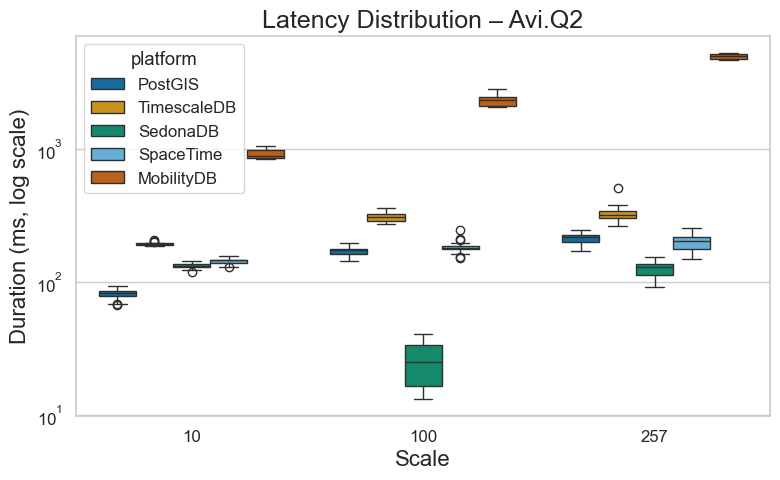

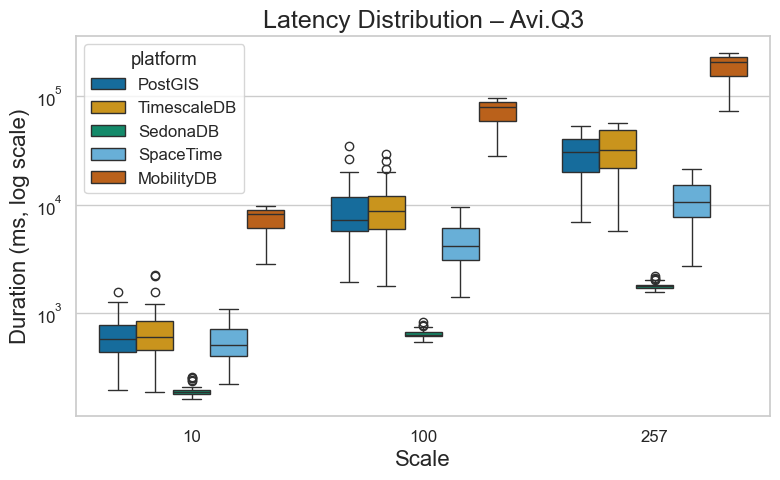

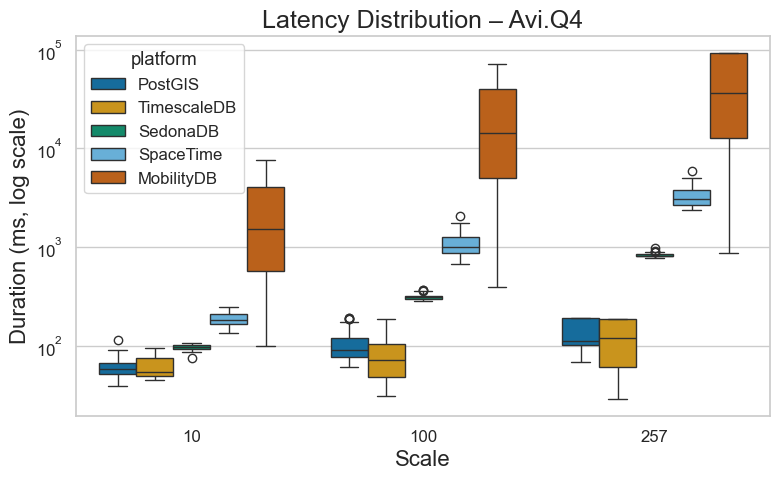

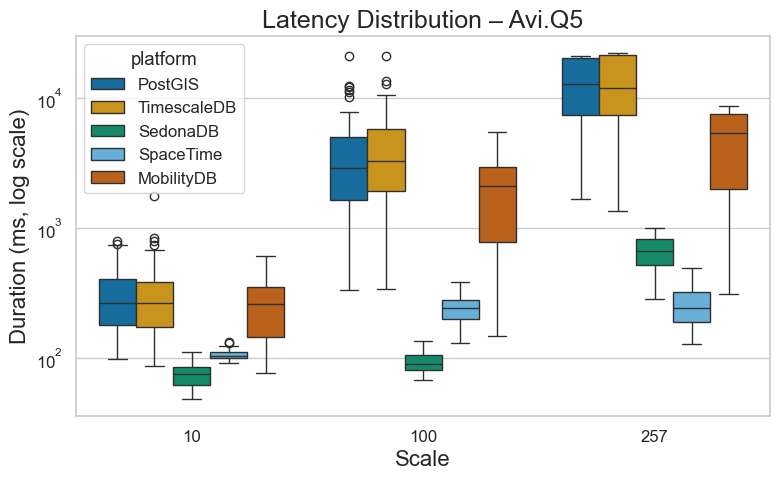

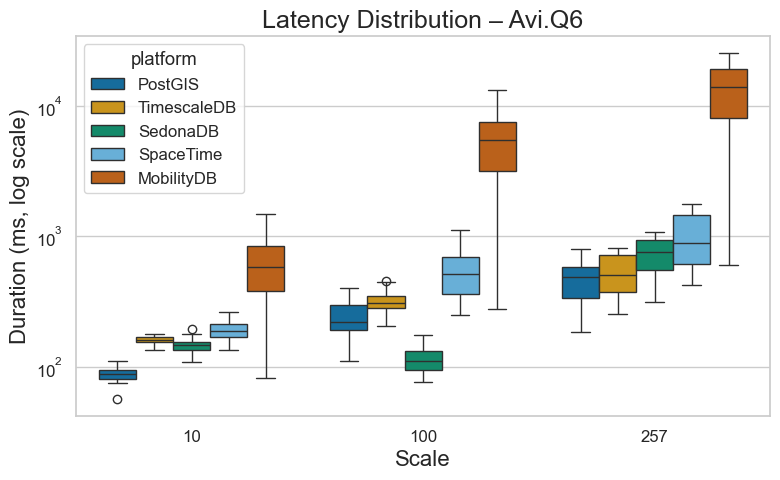

✅ Boxplots created.


In [28]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

QUERY_RENAME_MAP = {
    "FlightUpdatesInPeriod": "Avi.Q1",
    "airportUtilizationInPeriod": "Avi.Q2",
    "countFlightsInCounties": "Avi.Q3",
    "flightClosestToPoint": "Avi.Q4",
    "flightsInCountyInPeriod": "Avi.Q5",
    "inCityRadiusInPeriod": "Avi.Q6",
}

QUERY_ORDER = ["Avi.Q1", "Avi.Q2", "Avi.Q3", "Avi.Q4", "Avi.Q5", "Avi.Q6"]

PLATFORM_ORDER = [
    "PostGIS",
    "TimescaleDB",
    "SedonaDB",
    "SpaceTime",
    "MobilityDB",
]

PLATFORM_COLORS = {
    "PostGIS": "#0072B2",
    "TimescaleDB": "#E69F00",
    "SedonaDB": "#009E73",
    "SpaceTime": "#56B4E9",   # lighter blue
    "MobilityDB": "#D55E00",
}

SCALES = [10, 100, 257]

log_pattern = re.compile(
    r"\[.*?\]\s+\[(?P<platform>[\w_]+)\]\s+\[.*?\]\s+SUCCESS:\s+'(?P<query>[^']+)':\s+(?P<duration>\d+)ms"
)
log_pattern_alt = re.compile(
    r"\[?(?P<platform>[\w_]+)\]?\s+\[(?P<query>\w+)\]\s+query:\s+(?P<query_name>[^:]+):\s+(?P<duration>\d+\.?\d*)ms"
)


def parse_logs_for_identifier(identifier: str, scale: int, log_dir: Path):
    files = sorted(log_dir.glob(f"*{identifier}*.log"))
    dfs = []

    for f in files:
        rows = []
        with open(f, "r", encoding="utf-8") as file:
            for line in file:
                m = log_pattern.search(line)
                if m:
                    rows.append({
                        "platform": m.group("platform"),
                        "query_type": m.group("query"),
                        "duration_ms": int(m.group("duration")),
                        "scale": scale
                    })
                else:
                    m = log_pattern_alt.search(line)
                    if m:
                        rows.append({
                            "platform": m.group("platform"),
                            "query_type": m.group("query_name"),
                            "duration_ms": float(m.group("duration")),
                            "scale": scale
                        })
        if rows:
            dfs.append(pd.DataFrame(rows))

    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()


def clip_outliers_iqr(df, column):
    def clip(group):
        q1 = group[column].quantile(0.25)
        q3 = group[column].quantile(0.75)
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        group[column] = group[column].clip(lower, upper)
        return group
    return df.groupby(["platform", "query_type"], group_keys=False).apply(clip)


def analyze_queries(*identifiers):
    log_dir = Path("../logs")

    dfs = []
    for scale, identifier in zip(SCALES, identifiers):
        df = parse_logs_for_identifier(identifier, scale, log_dir)
        if not df.empty:
            dfs.append(df)

    df = pd.concat(dfs, ignore_index=True)

    df["query_type"] = df["query_type"].replace(QUERY_RENAME_MAP)
    df["query_type"] = pd.Categorical(df["query_type"], QUERY_ORDER, ordered=True)
    df["platform"] = pd.Categorical(df["platform"], PLATFORM_ORDER, ordered=True)

    df["occurrence_rank"] = df.groupby(
        ["platform", "query_type", "scale"]
    ).cumcount() + 1
    df = df[df["occurrence_rank"] > 2]

    df = clip_outliers_iqr(df, "duration_ms")

    sns.set(style="whitegrid", font_scale=1.1)

    for query in QUERY_ORDER:
        subset = df[df["query_type"] == query]

        plt.figure(figsize=(8, 5))
        ax = sns.boxplot(
            data=subset,
            x="scale",
            y="duration_ms",
            hue="platform",
            order=SCALES,
            hue_order=PLATFORM_ORDER,
            palette=PLATFORM_COLORS,
        )
        plt.xlabel("Scale", fontsize=16)
        plt.ylabel("Duration (ms)", fontsize=16)
        if query in ["Avi.Q2","Avi.Q3", "Avi.Q4", "Avi.Q5", "Avi.Q6"]:
            plt.yscale("log")
            plt.ylabel("Duration (ms, log scale)")
        plt.title(f"Latency Distribution – {query}", fontsize=18)
        plt.tight_layout()
        
        plt.savefig(f"boxplot_{query}_{'_'.join(identifiers)}.pdf", dpi=300)
        plt.show()

    print("✅ Boxplots created.")


if __name__ == "__main__":
    analyze_queries("4084d", "22222", "11111")


/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_75789/3000210435.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby(["platform", "query_type"], group_keys=False).apply(iqr_clip)
/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_75789/3000210435.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="platform", y="duration_ms", palette="Set2", ax=ax)
/var/folders/bn/_qwbp7jd1xqbgg501f948p540000gn/T/ipykernel_75789/3000210435.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is de

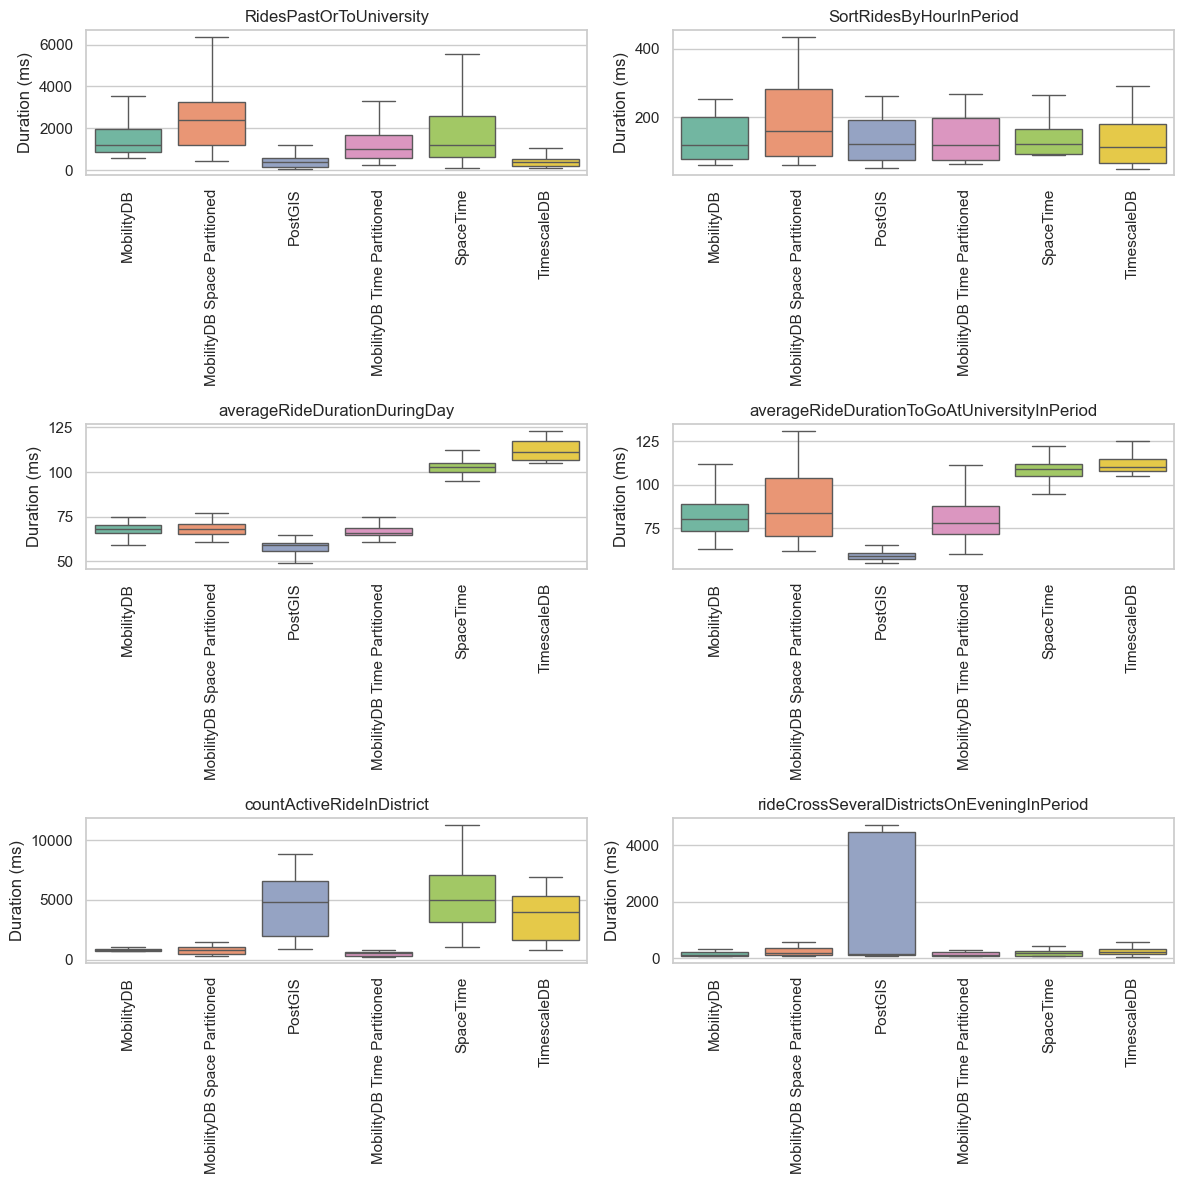

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


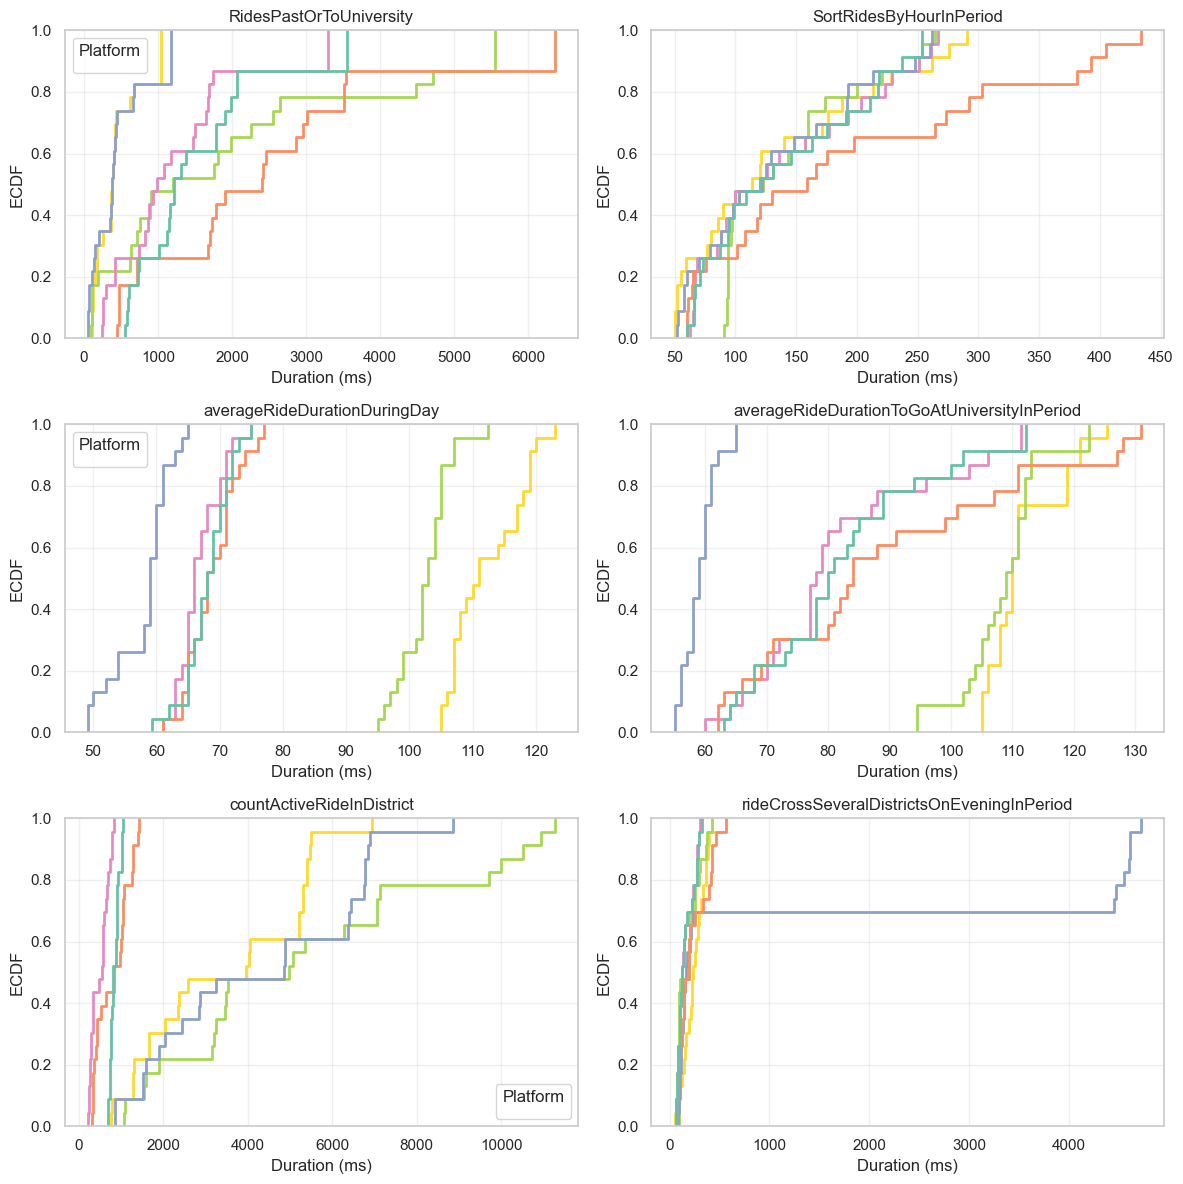

,platform,query_type,duration_ms,occurrence_rank
5,MobilityDB,countActiveRideInDistrict,906.0,3
7,MobilityDB,countActiveRideInDistrict,811.0,4
8,MobilityDB,RidesPastOrToUniversity,2069.0,3
15,MobilityDB,averageRideDurationDuringDay,68.0,3
16,MobilityDB,SortRidesByHourInPeriod,94.0,3
...,...,...,...,...
895,TimescaleDB,RidesPastOrToUniversity,108.0,25
896,TimescaleDB,rideCrossSeveralDistrictsOnEveningInPeriod,68.0,23
897,TimescaleDB,averageRideDurationDuringDay,110.0,25
898,TimescaleDB,rideCrossSeveralDistrictsOnEveningInPeriod,151.0,24


In [31]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from itertools import combinations
import math

def analyze_queries_subplots(file_ending: str):
    """
    Analyze query performance and produce multi-panel subplots per query.
    Saves all plots as PDFs.

    Legend renaming:
        Space_Partitioned -> Space Partitioned
        DB_Partitioned    -> Time Partitioned
    """
    log_dir = Path("../logs")
    log_pattern = re.compile(
        r"\[.*?\]\s+\[(?P<platform>\w+)\]\s+\[.*?\]\s+SUCCESS:\s+'(?P<query>[^']+)':\s+(?P<duration>\d+)ms"
    )
    log_pattern_alt = re.compile(
        r"\[?(?P<platform>\w+)\]?\s+\[(?P<query>\w+)\]\s+query:\s+(?P<query_name>[^:]+):\s+(?P<duration>\d+\.?\d*)ms"
    )

    # Load logs
    log_files = list(log_dir.glob(f"*{file_ending}.log"))
    if not log_files:
        print(f"No log files found ending with '{file_ending}'")
        return

    all_data = []
    for log_file in log_files:
        with open(log_file, "r", encoding="utf-8") as f:
            for line in f:
                m = log_pattern.search(line)
                if m:
                    all_data.append({
                        "platform": m.group("platform"),
                        "query_type": m.group("query"),
                        "duration_ms": int(m.group("duration"))
                    })
                else:
                    m2 = log_pattern_alt.search(line)
                    if m2:
                        all_data.append({
                            "platform": m2.group("platform"),
                            "query_type": m2.group("query_name"),
                            "duration_ms": float(m2.group("duration"))
                        })

    if not all_data:
        print("No valid log entries found.")
        return

    df = pd.DataFrame(all_data)

    # --- Rename platforms for legend ---
    def rename_platform(name):
        if "Space_Partitioned" in name:
            return "MobilityDB Space Partitioned"
        elif "DB_Partitioned" in name:
            return "MobilityDB Time Partitioned"
        else:
            return name
    df["platform"] = df["platform"].apply(rename_platform)

    platforms = sorted(df["platform"].unique())

    # Remove first 2 occurrences
    df["occurrence_rank"] = df.groupby(["platform", "query_type"]).cumcount() + 1
    df = df[df["occurrence_rank"] > 2].copy()

    # Clip outliers
    def clip_outliers_iqr(data, column):
        def iqr_clip(group):
            q1 = group[column].quantile(0.25)
            q3 = group[column].quantile(0.75)
            iqr = q3 - q1
            group[column] = group[column].clip(q1 - 1.5*iqr, q3 + 1.5*iqr)
            return group
        return data.groupby(["platform", "query_type"], group_keys=False).apply(iqr_clip)

    df = clip_outliers_iqr(df, "duration_ms")

    # Unique queries
    queries = sorted(df["query_type"].unique())
    n_queries = len(queries)
    n_cols = 2
    n_rows = math.ceil(n_queries / n_cols)

    # --- Multi-panel Boxplots ---
    sns.set(style="whitegrid", font_scale=1.0)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows), squeeze=False)

    for idx, query in enumerate(queries):
        ax = axes[idx//n_cols, idx%n_cols]
        subset = df[df["query_type"]==query]
        sns.boxplot(data=subset, x="platform", y="duration_ms", palette="Set2", ax=ax)
        ax.set_title(query)
        ax.set_xlabel("")
        ax.set_ylabel("Duration (ms)")
        ax.tick_params(axis='x', rotation=90)

    # Remove empty subplots
    for idx in range(n_queries, n_rows*n_cols):
        fig.delaxes(axes[idx//n_cols, idx%n_cols])

    plt.tight_layout()
    plt.savefig(f"query_boxplots_subplots_{file_ending}.pdf", dpi=300)
    plt.show()

    # --- Multi-panel ECDF plots ---
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows), squeeze=False)
    for idx, query in enumerate(queries):
        ax = axes[idx//n_cols, idx%n_cols]
        subset = df[df["query_type"]==query]
        sns.ecdfplot(data=subset, x="duration_ms", hue="platform", ax=ax, palette="Set2", linewidth=2)
        ax.set_title(query)
        ax.set_xlabel("Duration (ms)")
        ax.set_ylabel("ECDF")
        ax.grid(True, alpha=0.3)
        # Only show legend on first column or last row to reduce clutter
        if idx%n_cols == 0:
            ax.legend(title="Platform")
        else:
            ax.get_legend().remove()

    # Remove empty subplots
    for idx in range(n_queries, n_rows*n_cols):
        fig.delaxes(axes[idx//n_cols, idx%n_cols])

    plt.tight_layout()
    plt.savefig(f"query_ecdf_subplots_{file_ending}.pdf", dpi=300)
    plt.show()

    return df

analyze_queries_subplots("80b8e")
